In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import nltk  
import re 
from string import punctuation
from nltk import word_tokenize
from nltk.tokenize import WordPunctTokenizer, PunktSentenceTokenizer
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

import string
import os
import pickle

from textblob import Word

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import Input, Embedding, LSTM, Dense

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\43664\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\43664\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\43664\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\43664\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


ImportError: cannot import name 'pad_sequences' from 'keras.preprocessing.sequence' (C:\Users\43664\anaconda3\lib\site-packages\keras\preprocessing\sequence.py)

## Read and inspect data

In [129]:
raw_train_data = pd.read_csv('train.csv')
raw_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [96]:
raw_train_data.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [97]:
raw_train_data.dtypes

id               int64
qid1             int64
qid2             int64
question1       object
question2       object
is_duplicate     int64
dtype: object

In [4]:
### FOR LATER USE ##

#raw_test_data = pd.read_csv('test.csv')
#raw_test_data.head(5)

C:\Users\43664\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [98]:
print(raw_train_data.isnull().sum())

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64


In [5]:
#raw_test_data.isnull().sum()

test_id      0
question1    4
question2    6
dtype: int64

## Data Preparation

In [130]:
train_data = raw_train_data.dropna(axis=0)
#test_data = raw_test_data.dropna(axis=0)

In [100]:
train_data.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [9]:
test_data.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [131]:
train_data = train_data.drop(['id', 'qid1', 'qid2'], axis=1)
train_data.head(5)

,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [104]:
train_data['question1'].iloc[0]

'What is the step by step guide to invest in share market in india?'

In [205]:
train_copy = train_data.copy()

## Text Preparation 
####  # before normalization # ##  

In [206]:
## REMOVE ACCENTED CHARACTERS Sómě Áccěntěd těxt ##
import unicodedata

def remove_accented_chars_func(text):
    return unicodedata.normalize('NFKD', str(text)).encode('ascii', 'ignore').decode('utf-8', 'ignore')

## REMOVE PUNCTUATION ##

def remove_punctuation_func(text):
    return re.sub(r'[^a-zA-Z0-9]', ' ', str(text))

## REMOVE IRRELEVANT CHARACTERS 

def remove_irr_char_func(text):
    return re.sub(r'[^a-zA-Z]', ' ', str(text))

## REMOVE EXTRA WHITESPACEs ##

def remove_extra_whitespaces_func(text):
    return re.sub(r'^\s*|\s\s*', ' ', str(text)).strip()

## COUNT OF STRINGS ##

def word_count_func(text):
    return len(str(text).split())

## REMOVE HASHTAG IN FRONT OF A TEXT##

def remove_hashtag(text):
    return re.sub(r'#([^\s]+)', r'\1', str(text))

In [207]:
train_copy['question1'] = train_copy['question1'].str.lower()
train_copy['question2'] = train_copy['question2'].str.lower()

train_copy['question1'] = train_copy['question1'].apply(remove_accented_chars_func)
train_copy['question2'] = train_copy['question2'].apply(remove_accented_chars_func)

train_copy['question1'] = train_copy['question1'].apply(remove_punctuation_func)
train_copy['question2'] = train_copy['question2'].apply(remove_punctuation_func)

train_copy['question1'] = train_copy['question1'].apply(remove_irr_char_func)
train_copy['question2'] = train_copy['question2'].apply(remove_irr_char_func)

train_copy['question1'] = train_copy['question1'].apply(remove_extra_whitespaces_func)
train_copy['question2'] = train_copy['question2'].apply(remove_extra_whitespaces_func)

train_copy['question1'] = train_copy['question1'].apply(remove_hashtag)
train_copy['question2'] = train_copy['question2'].apply(remove_hashtag)

train_copy.head(5)

,question1,question2,is_duplicate
0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,what is the story of kohinoor koh i noor diamond,what would happen if the indian government sto...,0
2,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0
3,why am i mentally very lonely how can i solve it,find the remainder when math math is divided by,0
4,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0


In [208]:
train_prep_copy = train_copy.copy()

## Split data

In [281]:
features = ['question1', 'question2']

X_data = train_prep_copy[features]
X_data.head()

,question1,question2
0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...
1,what is the story of kohinoor koh i noor diamond,what would happen if the indian government sto...
2,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...
3,why am i mentally very lonely how can i solve it,find the remainder when math math is divided by
4,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water


In [282]:
y_data = train_prep_copy['is_duplicate']
y_data.head(5)

0    0
1    0
2    0
3    0
4    0
Name: is_duplicate, dtype: int64

In [283]:
# Split the set into train and split data into 60/40, random_state 0 

### BIG TEST SIZE JUST TO TRY ###

from sklearn.model_selection import train_test_split
X_train, X_split, y_train, y_split = train_test_split(X_data, y_data, test_size=0.99, random_state = 0)  ## cambiar test size

print("Whole dataset: ", len(train_copy))
print("X_train size =", len(X_train))
print("X_split size =", len(X_split))
print("y_train size =", len(y_train))
print("y_split size =", len(y_split))

Whole dataset:  404287
X_train size = 4042
X_split size = 400245
y_train size = 4042
y_split size = 400245


In [287]:
# Split the set into test and validation into 50/50 (from 40% of the splitted data), random_state 0

### BIG TEST SIZE JUST TO TRY ###

from sklearn.model_selection import train_test_split
X_test, X_val, y_test, y_val = train_test_split(X_split, y_split, test_size=0.98, random_state = 0)

print("Whole dataset: ", len(train_copy))
print("X_test size =", len(X_test))
print("X_val size =", len(X_val))
print("y_test size =", len(y_test))
print("y_val size =", len(y_val))

Whole dataset:  404287
X_test size = 8004
X_val size = 392241
y_test size = 8004
y_val size = 392241


In [143]:
X_val.head(5)

,question1,question2
189347,what are the most asked mainframe interview qu...,what is the most asked question in an interview
327140,how long should i wait for my bitcoin core wal...,can one set up a bitcoin wallet under false id...
126940,i got selected for internship at inria th june...,i got selected for internship at inria th june...
78406,how do you stay fit if you don t like the gym,how can i stay fit with out going gym
372855,what is the best budget hotels in cochin for a...,what is the best budget hotels in mussoorie fo...


## Text Normalization

## Tokenization

In [247]:
### X TRAIN QUESTION 1 ###

# lowecase #
X_train['question1'] = X_train['question1'].apply(lambda x: " ".join(x.lower() for x in x.split())) 
# stopwords #
stop = stopwords.words('english') 
X_train['question1'] = X_train['question1'].apply(lambda x: " ".join(x for x in x.split() if x not in stop)) 
# Stemming #
st = PorterStemmer() 
X_train['question1'] = X_train['question1'].apply(lambda x: " ".join([st.stem(word) for word in x.split()])) 
# Lemmatization
X_train['question1'] = X_train['question1'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) 
# check data 
X_train['question1'].head(20)

198725    begin take donald trump elect presid think may...
358600                               mani leg butterfli use
118674           true sweden largest number rape case europ
133697                          revenu model socialtrad biz
365383    net protector antiviru good comparison quickhe...
275582    use recurr tree determin good asymptot upper b...
186867                               best way evalu student
162362                unabl ping anoth comput local network
290904                         peopl vomit drink much avoid
378274      histori port blair andaman nicobar island india
128761                 real world applic depth first search
6262      birth control pill make period lighter help ge...
354102                            like live isra settlement
270520                          know dr ahm khan time india
340352                         differ differ spell muhammad
68380                  lose weight quickli need seriou help
30159                                   

In [248]:
### X TRAIN QUESTION 2 ###

# lowecase #
X_train['question2'] = X_train['question2'].apply(lambda x: " ".join(x.lower() for x in x.split())) 
# stopwords #
stop = stopwords.words('english') 
X_train['question2'] = X_train['question2'].apply(lambda x: " ".join(x for x in x.split() if x not in stop)) 
# Stemming #
st = PorterStemmer() 
X_train['question2'] = X_train['question2'].apply(lambda x: " ".join([st.stem(word) for word in x.split()])) 
# Lemmatization
X_train['question2'] = X_train['question2'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) 
# check data 
X_train['question2'].head(20)

198725                     donald trump potenti good presid
358600                 ok chest leg day squat use leg press
118674                   true sweden becam rape capit europ
133697                                 revenu model openbay
365383    urgent net protector antiviru ran window vulne...
275582    use recurr tree determin good asymptot upper b...
186867                                          evalu peopl
162362           comput network network comput thing differ
290904                                    peopl vomit drink
378274        thing port blair andaman nicobar island india
128761           real world applic depth first search graph
6262                      birth control make period lighter
354102                  like live isra settlement west bank
270520                                  best busi indonesia
340352              differ mose muhammad jew muslim respect
68380                       lose weight reduc waist quickli
30159                                   

In [273]:
X_train

,question1,question2
198725,as i begin to take in that donald trump has be...,does donald trump have any potential to be a g...
358600,how many legs do butterflies have what are the...,is it ok to do chest and legs on the same day ...
118674,it is true that sweden has the largest number ...,is it true that sweden became the rape capital...
133697,what is the revenue model of socialtrade biz,what is the revenue model of openbay
365383,how is net protector antivirus is it good in c...,urgent my net protector antivirus ran a window...
...,...,...
359785,what are java and android,what is r java in android
358085,what is the proper length for men s pants,what is the proper length for men s suit pants
152316,how do i know whether i want to do mbbs or som...,how do i know if i really want to become a doctor
117953,how can i hack the snapchat chat history,what do you do to spy on snapchat chat history


In [286]:
X_train

,question1,question2
198725,[begintakedonaldtrumpelectedpresidentthinkmaya...,does donald trump have any potential to be a g...
358600,[manylegsbutterfliesus],is it ok to do chest and legs on the same day ...
118674,[trueswedenlargestnumberrapecaseeurop],is it true that sweden became the rape capital...
133697,[revenuemodelsocialtradebiz],what is the revenue model of openbay
365383,[netprotectorantivirusgoodcomparisonquickhealk...,urgent my net protector antivirus ran a window...
...,...,...
359785,[javaandroid],what is r java in android
358085,[properlengthmenp],what is the proper length for men s suit pants
152316,[knowwhetherwantmbbssomethingels],how do i know if i really want to become a doctor
117953,[hacksnapchatchathistori],what do you do to spy on snapchat chat history


In [274]:
X_test

,question1,question2
219792,what do guys really think about inexperienced ...,do men like inexperienced women
16869,will china disintegrate,when will china disintegrate like ussr
290702,what are the hardest adjustments to make when ...,what are the hardest adjustments to make when ...
264517,what is the cost of starting global cable news...,what is the best site to read dc and marvel co...
59137,where can i find hyderabadi biryani in chennai,what are some cool ways to say yes i love hyde...
...,...,...
318307,where can i get funding for my idea,how do i get seed funding pre product
87313,top question that ask your coo when you plan a...,did anyone else feel compelled to ask a random...
359441,what would a socially conservative and fiscall...,were the dixiecrats fiscally liberal
319994,why do so many people not like jazz,how are many non korean people addicted to kpop


In [279]:
stop = set(stopwords.words('english')) 
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()
st = PorterStemmer()

def clean(doc): 
    stop_free = "".join([i for i in doc.lower().split() if i not in stop]) 
    punc_free = "".join(ch for ch in stop_free if ch not in exclude) 
    normalized = "".join(lemma.lemmatize(word) for word in punc_free.split())
    stemmed = "".join(st.stem(word) for word in normalized.split())
    return stemmed

In [285]:
X_train['question1'] = [clean(doc).split()for doc in X_train['question1']]


In [251]:
### X TEST QUESTION 1 ###

# lowecase #
X_test['question1'] = X_test['question1'].apply(lambda x: " ".join(x.lower() for x in x.split())) 
# stopwords #
stop = stopwords.words('english') 
X_test['question1'] = X_test['question1'].apply(lambda x: " ".join(x for x in x.split() if x not in stop)) 
# Stemming #
st = PorterStemmer()
X_test['question1'] = X_test['question1'].apply(lambda x: " ".join([st.stem(word) for word in x.split()])) 
# Lemmatization
X_test['question1'] = X_test['question1'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) 
# check data 
X_test['question1'].head(20)

219792                   guy realli think inexperienc woman
16869                                       china disintegr
290702                    hardest adjust make visit georgia
264517                  cost start global cabl news network
59137                       find hyderabadi biryani chennai
94133                                    mani engin postmat
219412    programm quora start old languag ever good wit...
263888    scienc much progress scientist made bring back...
361011                                overcom heroin addict
340358          would happen earth extra moon one big phobo
57259              english word use convers indian use much
144097                              rare exampl silli bandz
369874                                 lose belli fat india
8698                     exampl conspiraci theori turn true
390256                                    chemic equat form
318098                                  live year manhattan
392478                                  

In [252]:
### X TEST QUESTION 2 ###

# lowecase #
X_test['question2'] = X_test['question2'].apply(lambda x: " ".join(x.lower() for x in x.split())) 
# stopwords #
stop = stopwords.words('english') 
X_test['question2'] = X_test['question2'].apply(lambda x: " ".join(x for x in x.split() if x not in stop)) 
# Stemming #
st = PorterStemmer() 
X_test['question2'] = X_test['question2'].apply(lambda x: " ".join([st.stem(word) for word in x.split()])) 
# Lemmatization
X_test['question2'] = X_test['question2'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) 
# check data 
X_test['question2'].head(20)

219792                           men like inexperienc woman
16869                             china disintegr like ussr
290702                 hardest adjust make visit netherland
264517                  best site read dc marvel comic free
59137        cool way say ye love hyderabad love hyderabadi
94133                 mani engin pas everi year switzerland
219412              ever recogn street result quora popular
263888                   scienc capabl bring dead back life
361011                                   quit heroin addict
340358                          would happen earth one moon
57259      approxim mani mark score get rand around srm jee
144097    scientolog scriptur mean famili good group the...
369874                                effect lose belli fat
8698                            conspiraci theori turn real
390256                                 complet chemic equat
318098              much someon make live comfort manhattan
392478                                  

In [ ]:
### X VAL QUESTION 1 ###

# lowecase #
X_val['question1'] = X_val['question1'].apply(lambda x: " ".join(x.lower() for x in x.split())) 
# stopwords #
stop = stopwords.words('english') 
X_val['question1'] = X_val['question1'].apply(lambda x: " ".join(x for x in x.split() if x not in stop)) 
# Stemming #
st = PorterStemmer() 
X_val['question1'] = X_val['question1'].apply(lambda x: " ".join([st.stem(word) for word in x.split()])) 
# Lemmatization
X_val['question1'] = X_val['question1'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) 
# check data 
X_val['question1'].head(20)

In [290]:
### X VAL QUESTION 2 ###

# lowecase #
X_val['question2'] = X_val['question2'].apply(lambda x: " ".join(x.lower() for x in x.split())) 

# Tokenization #
X_val['question2'] = X_val['question2'].apply(lambda x: " ".join(x.word_tokenize() for x in x.split()))

# stopwords #
stop = stopwords.words('english') 
X_val['question2'] = X_val['question2'].apply(lambda x: " ".join(x for x in x.split() if x not in stop)) 
# Stemming #
st = PorterStemmer() 
X_val['question2'] = X_val['question2'].apply(lambda x: " ".join([st.stem(word) for word in x.split()])) 
# Lemmatization
X_val['question2'] = X_val['question2'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) 
# check data 
X_val['question2'].head(20)

AttributeError: 'str' object has no attribute 'word_tokenize'

In [145]:
### X_train ###
## QUESTION 1 ##
X_train_text_q1 = X_train['question1'] 

X_train_q1 = []

for sent_train_q1 in X_train_text_q1:
    
    #lowercase
    #sent = sent.lower()
  
    sent_train_q1 = sent_train_q1.translate(str.maketrans('', '', string.punctuation))

  ## tokenize ##
    train_tokens_q1 = nltk.word_tokenize(sent_train_q1)

  ## remove stop-words ##
    english_stopwords = stopwords.words('english')
    #english_stopwords = english_stopwords + ['did', 'could', 'would', 'have', 'had', 'has', 'might', 'should', 'was', 'were', 'does', 'much', 'br', 'n']
    train_tokens_q1 = [el for el in train_tokens_q1 if not el in english_stopwords]
    
 ## stemming ##

    #stemmed_tokens = [PorterStemmer().stem(el) for el in train_tokens_q1]
      
  ## add to output list ##
    X_train_q1.append(" ".join(train_tokens_q1))

In [146]:
### X_train ###
## QUESTION 2 ##
X_train_text_q2 = X_train['question2'] 

X_train_q2 = []

for sent_train_q2 in X_train_text_q2:
    
    #lowercase
    #sent = sent.lower()
  
    sent_train_q2 = sent_train_q2.translate(str.maketrans('', '', string.punctuation))

  ## tokenize ##
    train_tokens_q2 = nltk.word_tokenize(sent_train_q2)

  ## remove stop-words ##
    english_stopwords = stopwords.words('english')
    #english_stopwords = english_stopwords + ['did', 'could', 'would', 'have', 'had', 'has', 'might', 'should', 'was', 'were', 'does', 'much', 'br', 'n']
    train_tokens_q2 = [el for el in train_tokens_q2 if not el in english_stopwords]

   ## stemming ##

    #stemmed_tokens = [PorterStemmer().stem(el) for el in train_tokens_q2]

  ## add to output list ##
    X_train_q2.append(" ".join(train_tokens_q2))

In [147]:
### X_test ###
## QUESTION 1 ##
X_test_text_q1 = X_test['question1'] 

X_test_q1 = []

for sent_test_q1 in X_test_text_q1:
    
    #lowercase
    #sent = sent.lower()
  
    sent_test_q1 = sent_test_q1.translate(str.maketrans('', '', string.punctuation))

  ## tokenize ##
    test_tokens_q1 = nltk.word_tokenize(sent_test_q1)

  ## remove stop-words ##
    english_stopwords = stopwords.words('english')
    #english_stopwords = english_stopwords + ['did', 'could', 'would', 'have', 'had', 'has', 'might', 'should', 'was', 'were', 'does', 'much', 'br', 'n']
    test_tokens_q1 = [el for el in test_tokens_q1 if not el in english_stopwords]

  ## lemmatization ##
 
    #test_tokens_lemma_q1 = [wnl.lemmatize(el, get_wordnet_pos(nltk.pos_tag([el])[0][1])) for el in test_tokens_q1]
    
    ## stemming ##

    #stemmed_tokens = [PorterStemmer().stem(el) for el in test_tokens_q1]


  ## add to output list ##
    X_test_q1.append(" ".join(test_tokens_q1))

In [148]:
### X_test ###
## QUESTION 2 ##
X_test_text_q2 = X_test['question2'] 

X_test_q2 = []

for sent_test_q2 in X_test_text_q2:
    
    #lowercase
    #sent = sent.lower()
  
    sent_test_q2 = sent_test_q2.translate(str.maketrans('', '', string.punctuation))

  ## tokenize ##
    test_tokens_q2 = nltk.word_tokenize(sent_test_q2)

  ## remove stop-words ##
    english_stopwords = stopwords.words('english')
    #english_stopwords = english_stopwords + ['did', 'could', 'would', 'have', 'had', 'has', 'might', 'should', 'was', 'were', 'does', 'much', 'br', 'n']
    test_tokens_q2 = [el for el in test_tokens_q2 if not el in english_stopwords]

  ## lemmatization ##
 
    #test_tokens_lemma_q2 = [wnl.lemmatize(el, get_wordnet_pos(nltk.pos_tag([el])[0][1])) for el in test_tokens_q2]
    
    ## stemming ##

    #stemmed_tokens = [PorterStemmer().stem(el) for el in test_tokens_q2]


  ## add to output list ##
    X_test_q2.append(" ".join(test_tokens_q2))

In [160]:
### X_val ###
## QUESTION 1 ##
X_val_text_q1 = X_val['question1'] 

X_val_q1 = []

for sent_val_q1 in X_val_text_q1:
    
    #lowercase
    #sent = sent.lower()
  
    sent_val_q1 = sent_val_q1.translate(str.maketrans('', '', string.punctuation))

  ## tokenize ##
    val_tokens_q1 = nltk.word_tokenize(sent_val_q1)

  ## remove stop-words ##
    english_stopwords = stopwords.words('english')
    #english_stopwords = english_stopwords + ['did', 'could', 'would', 'have', 'had', 'has', 'might', 'should', 'was', 'were', 'does', 'much', 'br', 'n']
    val_tokens_q1 = [el for el in val_tokens_q1 if not el in english_stopwords]

  ## lemmatization ##
 
    #val_tokens_lemma_q1 = [wnl.lemmatize(el, get_wordnet_pos(nltk.pos_tag([el])[0][1])) for el in val_tokens_q1]
    
    ## stemming ##

    #stemmed_tokens = [PorterStemmer().stem(el) for el in val_tokens_q1]


  ## add to output list ##
    X_val_q1.append(" ".join(val_tokens_q1))

In [162]:
### X_val ###
## QUESTION 2 ##
X_val_text_q2 = X_val['question2'] 

X_val_q2 = []

for sent_val_q2 in X_val_text_q2:
    
    #lowercase
    #sent = sent.lower()
  
    sent_val_q2 = sent_val_q2.translate(str.maketrans('', '', string.punctuation))

  ## tokenize ##
    val_tokens_q2 = nltk.word_tokenize(sent_val_q2)

  ## remove stop-words ##
    english_stopwords = stopwords.words('english')
    #english_stopwords = english_stopwords + ['did', 'could', 'would', 'have', 'had', 'has', 'might', 'should', 'was', 'were', 'does', 'much', 'br', 'n']
    val_tokens_q2 = [el for el in val_tokens_q2 if not el in english_stopwords]

  ## lemmatization ##
 
    #val_tokens_lemma_q2 = [wnl.lemmatize(el, get_wordnet_pos(nltk.pos_tag([el])[0][1])) for el in val_tokens_q2]
    
    ## stemming ##

    #stemmed_tokens = [PorterStemmer().stem(el) for el in val_tokens_q2]


  ## add to output list ##
    X_val_q2.append(" ".join(val_tokens_q2))

In [149]:
# df_q1 = pd.DataFrame(X_train_q1, columns=['question1'])
# df_q2 = pd.DataFrame(X_train_q2, columns=['question2'])
# train_df = df_q1.join(df_q2, lsuffix='_left', rsuffix='_right')
# train_df

,question1,question2
0,begin take donald trump elected president thin...,donald trump potential good president
1,many legs butterflies used,ok chest legs day squat use leg press
2,true sweden largest number rape case europe,true sweden became rape capital europe
3,revenue model socialtrade biz,revenue model openbay
4,net protector antivirus good comparison quickh...,urgent net protector antivirus ran windows vul...
...,...,...
4037,java android,r java android
4038,proper length men pants,proper length men suit pants
4039,know whether want mbbs something else,know really want become doctor
4040,hack snapchat chat history,spy snapchat chat history


In [150]:
# df_q1 = pd.DataFrame(X_test_q1, columns=['question1'])
# df_q2 = pd.DataFrame(X_test_q2, columns=['question2'])
# test_df = df_q1.join(df_q2, lsuffix='_left', rsuffix='_right')
# test_df

,question1,question2
0,guys really think inexperienced women,men like inexperienced women
1,china disintegrate,china disintegrate like ussr
2,hardest adjustments make visiting georgia,hardest adjustments make visiting netherlands
3,cost starting global cable news network,best site read dc marvel comics free
4,find hyderabadi biryani chennai,cool ways say yes love hyderabad love hyderabadi
...,...,...
7999,get funding idea,get seed funding pre product
8000,top question ask coo plan business,anyone else feel compelled ask random question...
8001,would socially conservative fiscally liberal p...,dixiecrats fiscally liberal
8002,many people like jazz,many non korean people addicted kpop


## Labelling target variable

In [254]:
labels = preprocessing.LabelEncoder()
# Convert continous y values to categorical
y_train_cat= labels.fit_transform(y_train)
print(y_train_cat)

#y_val_cat = labels.fit_transform(y_val)
#print(y_val_cat)

y_test_cat = labels.fit_transform(y_test)
print(y_test_cat)

[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 1]


## try


In [177]:
# ## FIRST WAY TO APPLY COUNT VECTORIZER ##
# ## NEEDS TO BE IMPROVED ##
# from sklearn.feature_extraction.text import CountVectorizer

# questions = list(train_df['question1']) + list(train_df['question2'])

# vectorizer = CountVectorizer(analyzer='word')

# X_train_q1_arr, X_train_q2_arr = np.vsplit(vectorizer.fit_transform(questions).toarray(), 2)

## Text to Features - Count Vectorizer

In [260]:
from sklearn.feature_extraction.text import CountVectorizer

## X TRAIN QUESTION 1 ##

train_q1 = X_train['question1']

vectorizer = CountVectorizer()

vectorizer.fit(train_q1) 
vector_train_q1 = vectorizer.transform(train_q1)

print(vectorizer.vocabulary_)
print(vector_train_q1.toarray())

{'begin': 418, 'take': 4511, 'donald': 1312, 'trump': 4725, 'elect': 1422, 'presid': 3529, 'think': 4610, 'may': 2762, 'actual': 49, 'good': 1878, 'mani': 2713, 'leg': 2551, 'butterfli': 633, 'use': 4840, 'true': 4722, 'sweden': 4475, 'largest': 2514, 'number': 3106, 'rape': 3707, 'case': 692, 'europ': 1520, 'revenu': 3842, 'model': 2898, 'socialtrad': 4230, 'biz': 493, 'net': 3034, 'protector': 3590, 'antiviru': 212, 'comparison': 906, 'quickheal': 3668, 'kasperski': 2422, 'bitdefend': 490, 'recurr': 3748, 'tree': 4708, 'determin': 1215, 'asymptot': 295, 'upper': 4827, 'bound': 551, 'best': 440, 'way': 4991, 'evalu': 1523, 'student': 4413, 'unabl': 4773, 'ping': 3403, 'anoth': 205, 'comput': 924, 'local': 2620, 'network': 3037, 'peopl': 3334, 'vomit': 4954, 'drink': 1336, 'much': 2952, 'avoid': 337, 'histori': 2044, 'port': 3471, 'blair': 499, 'andaman': 186, 'nicobar': 3057, 'island': 2315, 'india': 2195, 'real': 3726, 'world': 5083, 'applic': 230, 'depth': 1195, 'first': 1681, 'sear

In [261]:
from sklearn.feature_extraction.text import CountVectorizer

## X TRAIN QUESTION 2 ##

train_q2 = X_train['question2']

vectorizer = CountVectorizer()

vectorizer.fit(train_q1) 
vector_train_q2 = vectorizer.transform(train_q2)

print(vectorizer.vocabulary_)
print(vector_train_q2.toarray())

{'begin': 418, 'take': 4511, 'donald': 1312, 'trump': 4725, 'elect': 1422, 'presid': 3529, 'think': 4610, 'may': 2762, 'actual': 49, 'good': 1878, 'mani': 2713, 'leg': 2551, 'butterfli': 633, 'use': 4840, 'true': 4722, 'sweden': 4475, 'largest': 2514, 'number': 3106, 'rape': 3707, 'case': 692, 'europ': 1520, 'revenu': 3842, 'model': 2898, 'socialtrad': 4230, 'biz': 493, 'net': 3034, 'protector': 3590, 'antiviru': 212, 'comparison': 906, 'quickheal': 3668, 'kasperski': 2422, 'bitdefend': 490, 'recurr': 3748, 'tree': 4708, 'determin': 1215, 'asymptot': 295, 'upper': 4827, 'bound': 551, 'best': 440, 'way': 4991, 'evalu': 1523, 'student': 4413, 'unabl': 4773, 'ping': 3403, 'anoth': 205, 'comput': 924, 'local': 2620, 'network': 3037, 'peopl': 3334, 'vomit': 4954, 'drink': 1336, 'much': 2952, 'avoid': 337, 'histori': 2044, 'port': 3471, 'blair': 499, 'andaman': 186, 'nicobar': 3057, 'island': 2315, 'india': 2195, 'real': 3726, 'world': 5083, 'applic': 230, 'depth': 1195, 'first': 1681, 'sear

In [262]:
from sklearn.feature_extraction.text import CountVectorizer

## X TEST QUESTION 1 ##

test_q1 = X_test['question1']

vectorizer = CountVectorizer()

vectorizer.fit(test_q1) 
vector_test_q1 = vectorizer.transform(test_q1)

print(vectorizer.vocabulary_)
print(vector_test_q1.toarray())

{'guy': 2809, 'realli': 5389, 'think': 6677, 'inexperienc': 3207, 'woman': 7358, 'china': 1168, 'disintegr': 1847, 'hardest': 2850, 'adjust': 96, 'make': 3894, 'visit': 7166, 'georgia': 2650, 'cost': 1485, 'start': 6278, 'global': 2682, 'cabl': 951, 'news': 4414, 'network': 4397, 'find': 2407, 'hyderabadi': 3056, 'biryani': 740, 'chennai': 1153, 'mani': 3926, 'engin': 2135, 'postmat': 5036, 'programm': 5155, 'quora': 5292, 'old': 4581, 'languag': 3624, 'ever': 2217, 'good': 2713, 'without': 7350, 'learn': 3673, 'scienc': 5794, 'much': 4276, 'progress': 5157, 'scientist': 5796, 'made': 3864, 'bring': 871, 'back': 520, 'dead': 1656, 'peopl': 4822, 'overcom': 4673, 'heroin': 2919, 'addict': 88, 'would': 7384, 'happen': 2841, 'earth': 2010, 'extra': 2284, 'moon': 4234, 'one': 4600, 'big': 713, 'phobo': 4882, 'english': 2138, 'word': 7365, 'use': 7039, 'convers': 1452, 'indian': 3191, 'rare': 5352, 'exampl': 2240, 'silli': 6005, 'bandz': 562, 'lose': 3809, 'belli': 662, 'fat': 2345, 'india'

In [264]:
from sklearn.feature_extraction.text import CountVectorizer

## X TEST QUESTION 2 ##

test_q2 = X_test['question2']

vectorizer = CountVectorizer()

vectorizer.fit(test_q2) 
vector_test_q2 = vectorizer.transform(test_q2)

print(vectorizer.vocabulary_)
print(vector_test_q2.toarray())

{'men': 3941, 'like': 3649, 'inexperienc': 3116, 'woman': 7013, 'china': 1117, 'disintegr': 1770, 'ussr': 6723, 'hardest': 2783, 'adjust': 88, 'make': 3792, 'visit': 6831, 'netherland': 4269, 'best': 643, 'site': 5788, 'read': 5187, 'dc': 1579, 'marvel': 3856, 'comic': 1254, 'free': 2454, 'cool': 1383, 'way': 6909, 'say': 5531, 'ye': 7079, 'love': 3729, 'hyderabad': 2978, 'hyderabadi': 2979, 'mani': 3816, 'engin': 2056, 'pas': 4625, 'everi': 2145, 'year': 7080, 'switzerland': 6208, 'ever': 2144, 'recogn': 5212, 'street': 6082, 'result': 5342, 'quora': 5119, 'popular': 4867, 'scienc': 5563, 'capabl': 954, 'bring': 836, 'dead': 1582, 'back': 499, 'life': 3638, 'quit': 5116, 'heroin': 2862, 'addict': 82, 'would': 7042, 'happen': 2775, 'earth': 1935, 'one': 4464, 'moon': 4122, 'approxim': 334, 'mark': 3839, 'score': 5571, 'get': 2573, 'rand': 5152, 'around': 368, 'srm': 5992, 'jee': 3336, 'scientolog': 5566, 'scriptur': 5585, 'mean': 3901, 'famili': 2247, 'good': 2640, 'group': 2705, 'they

In [256]:
from sklearn.feature_extraction.text import CountVectorizer
def count_vectorizer_func(text): 
    texto = text
    vectorizer = CountVectorizer()
    vectorizer.fit(texto)
    vector_texto = vectorizer.transform(texto)
    return vectorizer.vocabulary_
    #print(vector_texto.toarray())

In [258]:
# ERROR 
#vector_train_q1 = X_test['question2'].apply(count_vectorizer_func)


## N-GRAMS

In [259]:
from textblob import TextBlob

train_q1 = X_train['question1']

ngrams_train_q1 = TextBlob(str(train_q1)).ngrams(3)

#ngrams_train_q1

In [ ]:
from textblob import TextBlob

train_q2 = X_train['question2']

ngrams_train_q2 = TextBlob(str(train_q2)).ngrams(3)

#textblob

In [ ]:
from textblob import TextBlob

test_q1 = X_test['question1']

ngrams_test_q1 = TextBlob(str(test_q1)).ngrams(3)

#textblob

In [ ]:
from textblob import TextBlob

test_q2 = X_test['question2']

ngrams_test_q2 = TextBlob(str(test_q2)).ngrams(3)

#textblob

## TF-IDF

In [98]:
from sklearn.feature_extraction.text import TfidfVectorizer

## X TRAIN QUESTION 1 ##

train_q1 = X_train['question1']
vectorizer = TfidfVectorizer()
tfidf_train_q1 = vectorizer.fit_transform(train_q1)

print(tfidf_train_q1.shape)
#print(vectorizer.vocabulary_)
#print(vectorizer.idf_)

(4042, 6699)


In [99]:
## X TRAIN QUESTION 2 ##

train_q2 = X_train['question2']
vectorizer = TfidfVectorizer()
tfidf_train_q2 = vectorizer.fit_transform(train_q2)

print(tfidf_train_q1.shape)
#print(vectorizer.vocabulary_)
#print(vectorizer.idf_)



(4042, 6699)


In [ ]:
## X TEST QUESTION 1 ##

test_q1 = X_test['question1']

vectorizer = TfidfVectorizer()

tfidf_test_q1 = vectorizer.fit_transform(test_q1)
print(tfidf_train_q1.shape)
#print(vectorizer.vocabulary_)
#print(vectorizer.idf_)

In [ ]:
## X TEST QUESTION 2 ##

test_q2 = X_test['question2']

vectorizer = TfidfVectorizer()

tfidf_test_q2 = vectorizer.fit_transform(test_q2)
print(tfidf_train_q2.shape)
#print(vectorizer.vocabulary_)
#print(vectorizer.idf_)

## Cosine Similarity

In [102]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity(tfidf_X_train_q2[0:1], tfidf_X_train_q2)

#cosine_similarity(trsfm[0:1], trsfm)

array([[1., 0., 0., ..., 0., 0., 0.]])

In [127]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity(tfidf_X_train_q1[0:1], tfidf_X_train_q2)

ValueError: Incompatible dimension for X and Y matrices: X.shape[1] == 6699 while Y.shape[1] == 6417

## Word Embeddings

In [266]:
## 3. Word Embeddings ##

## X TRAIN QUESTION 1 ##

we_tokenizer = Tokenizer()
we_tokenizer.fit_on_texts(X_train['question1'])

sequences_train_q1 = np.array(we_tokenizer.texts_to_sequences(X_train['question1']))

#we_tokenizer.word_index

C:\Users\43664\AppData\Local\Temp/ipykernel_7224/306811233.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sequences_train_q1 = np.array(we_tokenizer.texts_to_sequences(X_train['question1']))


In [169]:
## X TRAIN QUESTION 2 ##
we_tokenizer = Tokenizer()
we_tokenizer.fit_on_texts(X_train['question2'])

sequences_train_q2 = np.array(we_tokenizer.texts_to_sequences(X_train['question2']))

C:\Users\43664\AppData\Local\Temp/ipykernel_7224/550052439.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sequences_q2 = np.array(we_tokenizer.texts_to_sequences(X_train['question2']))


In [170]:
## X TEST QUESTION 1 #
we_tokenizer = Tokenizer()
we_tokenizer.fit_on_texts(X_test['question1'])

sequences_test_q1 = np.array(we_tokenizer.texts_to_sequences(X_test['question1']))

array([list([43, 5, 727, 7, 98, 8, 24, 118, 78, 72, 181, 556, 148, 10, 15, 79, 204, 326, 410, 32, 6, 44, 148, 21, 117, 83, 31, 60, 1099, 7, 29, 6, 43, 151]),
       list([4, 83, 2982, 10, 2983, 26, 2, 11, 66, 187, 14, 3, 19, 1917, 7, 10, 2899, 13, 1416, 20, 1, 382, 137, 4, 115, 45, 2900, 13, 4, 99, 1, 1918, 1919]),
       list([19, 3, 270, 24, 2984, 72, 1, 1935, 124, 9, 874, 728, 8, 1936, 3, 19, 529, 28, 2901, 892, 1, 1417, 683, 9, 1100]),
       ...,
       list([4, 10, 5, 69, 834, 5, 73, 7, 10, 6851, 23, 294, 546, 5, 10, 4, 70, 26, 4, 182, 79, 7, 85, 6, 890]),
       list([4, 13, 5, 405, 1, 486, 6852, 231, 2, 10, 15, 10, 7, 6572, 20, 578, 1292, 300]),
       list([4, 72, 396, 359, 1188, 1, 85, 5, 72, 371, 6573, 1010, 1, 86])],
      dtype=object)

In [ ]:
## X TEST QUESTION 2 #
we_tokenizer = Tokenizer()
we_tokenizer.fit_on_texts(X_test['question2'])

sequences_test_q2 = np.array(we_tokenizer.texts_to_sequences(X_test['question2']))


In [267]:
X_train_we, X_test_we, Y_train, Y_test = train_test_split(sequences_train_q1, np.array(labels), random_state=42, shuffle=True, test_size=0.3)
print(X_train_we.shape)
print(X_test_we.shape)


max_len = 30
X_train_we_padded = pad_sequences(X_train_we, maxlen=max_len)
X_test_we_padded = pad_sequences(X_test_we, maxlen=max_len)
print(X_train_we_padded.shape)
print(X_test_we_padded.shape)

print(X_train_we[0])
print(X_train_we_padded[0])

vocab_size = len(we_tokenizer.word_index) + 1

TypeError: Singleton array array(LabelEncoder(), dtype=object) cannot be considered a valid collection.

## Word2Vect 

In [185]:
import pandas as pd
import nltk
import string
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk import word_tokenize
from gensim.models import Word2Vec as w2v
from sklearn.decomposition import PCA


texto = train_df['question1']
w = w2v(texto, min_count=3, sg=1, window=7)

In [191]:
emb_df = (pd.DataFrame([w.wv.get_vector(str(n)) for n in w.wv.key_to_index], 
                      index = w.wv.key_to_index
                      )
         )
print(emb_df.shape)
print(emb_df.head())

(27, 100)
         0         1         2         3         4         5         6   \
  -0.091287 -0.072540 -0.029185  0.026408  0.032271 -0.062796  0.062260   
e -0.094987  0.062690  0.129342  0.055432  0.013969 -0.081130  0.019054   
a -0.000032  0.057786  0.138453  0.043806  0.066739 -0.034047  0.026830   
i -0.086419  0.121831  0.124967  0.075001  0.109001 -0.104479 -0.014833   
t -0.047169  0.073875  0.020529  0.009770  0.032301 -0.057570  0.109777   

         7         8         9   ...        90        91        92        93  \
   0.234716 -0.123655 -0.087230  ...  0.069744  0.034897  0.122269 -0.065650   
e  0.256550 -0.122640 -0.181302  ...  0.082262 -0.003926  0.040047 -0.082950   
a  0.146708 -0.068438 -0.155368  ...  0.140770  0.026645  0.082311 -0.029388   
i  0.302338 -0.078011 -0.120528  ...  0.078283  0.025193  0.085876 -0.087448   
t  0.262458 -0.168771 -0.208575  ...  0.081503 -0.007298  0.001039 -0.028981   

         94        95        96        97        98       

[]

<Figure size 432x288 with 0 Axes>

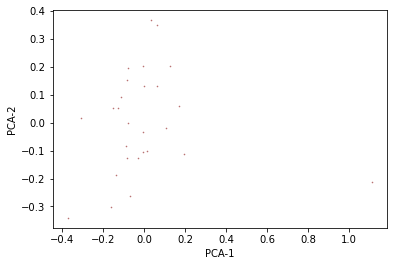

In [196]:
pca = PCA(n_components=2, random_state=7)
pca_mdl = pca.fit_transform(emb_df)

emb_df_PCA = (pd.DataFrame(
    pca_mdl, 
    columns=['x', 'y'], 
    index = emb_df.index))


plt.clf()
fig = plt.figure(figsize=(6, 4))

plt.scatter(x= emb_df_PCA['x'], 
            y=emb_df_PCA['y'],
            s = 0.4, 
            color = 'maroon', 
            alpha= 0.5
)

plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.plot()

In [199]:
stop = set(stopwords.words('english')) 
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()

#Kulkarni, Akshay; Shivananda, Adarsha. Natural Language Processing Recipes (p. 110). Apress. Kindle Edition. 

def clean(doc): 
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop]) 
    punc_free = "".join(ch for ch in stop_free if ch not in exclude) 
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split()) 
    return normalized

#Kulkarni, Akshay; Shivananda, Adarsha. Natural Language Processing Recipes (pp. 110-111). Apress. Kindle Edition. 

In [201]:
doc_clean = [clean(doc).split()for doc in train_df['question1']]
doc_clean

[['begin',
  'take',
  'donald',
  'trump',
  'elected',
  'president',
  'think',
  'may',
  'actually',
  'good',
  'president'],
 ['many', 'leg', 'butterfly', 'used'],
 ['true', 'sweden', 'largest', 'number', 'rape', 'case', 'europe'],
 ['revenue', 'model', 'socialtrade', 'biz'],
 ['net',
  'protector',
  'antivirus',
  'good',
  'comparison',
  'quickheal',
  'kaspersky',
  'bitdefender'],
 ['use',
  'recurrence',
  'tree',
  'determine',
  'good',
  'asymptotic',
  'upper',
  'bound',
  'recurrence'],
 ['best', 'way', 'evaluate', 'student'],
 ['unable', 'ping', 'another', 'computer', 'local', 'network'],
 ['people', 'vomit', 'drinking', 'much', 'avoided'],
 ['history', 'port', 'blair', 'andaman', 'nicobar', 'island', 'india'],
 ['real', 'world', 'application', 'depth', 'first', 'search'],
 ['birth',
  'control',
  'pill',
  'make',
  'period',
  'lighter',
  'help',
  'get',
  'rid',
  'hormonal',
  'acne'],
 ['like', 'live', 'israeli', 'settlement'],
 ['know', 'dr', 'ahmed', 'kha

In [202]:
train_df['question1']

0       begin take donald trump elected president thin...
1                              many legs butterflies used
2             true sweden largest number rape case europe
3                           revenue model socialtrade biz
4       net protector antivirus good comparison quickh...
                              ...                        
4037                                         java android
4038                              proper length men pants
4039                know whether want mbbs something else
4040                           hack snapchat chat history
4041                           social media changed world
Name: question1, Length: 4042, dtype: object

In [203]:
import gensim 
from gensim import corpora
dictionary = corpora.Dictionary(doc_clean)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
doc_term_matrix

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 2),
  (7, 1),
  (8, 1),
  (9, 1)],
 [(10, 1), (11, 1), (12, 1), (13, 1)],
 [(14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1)],
 [(21, 1), (22, 1), (23, 1), (24, 1)],
 [(4, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1)],
 [(4, 1), (32, 1), (33, 1), (34, 1), (35, 2), (36, 1), (37, 1), (38, 1)],
 [(39, 1), (40, 1), (41, 1), (42, 1)],
 [(43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1)],
 [(49, 1), (50, 1), (51, 1), (52, 1), (53, 1)],
 [(54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1)],
 [(61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1)],
 [(67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1)],
 [(78, 1), (79, 1), (80, 1), (81, 1)],
 [(57, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1)],
 [(87, 1), (88, 1), (89, 1), (90, 1)],
 [(71, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1)],
 [(96, 1), (97, 1)],
 [(70

In [204]:
Lda = gensim.models.ldamodel.LdaModel

ldamodel = Lda(doc_term_matrix, num_topics=3, id2word=dictionary, passes=50)
print(ldamodel.print_topics())

[(0, '0.014*"many" + 0.012*"real" + 0.011*"one" + 0.010*"java" + 0.010*"like" + 0.010*"text" + 0.009*"better" + 0.009*"make" + 0.007*"university" + 0.007*"world"'), (1, '0.012*"nagar" + 0.010*"get" + 0.009*"life" + 0.009*"possible" + 0.009*"world" + 0.009*"food" + 0.009*"money" + 0.009*"time" + 0.008*"know" + 0.008*"people"'), (2, '0.020*"best" + 0.013*"quora" + 0.013*"india" + 0.010*"way" + 0.007*"difference" + 0.007*"learn" + 0.006*"people" + 0.006*"good" + 0.006*"woman" + 0.006*"using"')]


In [223]:
X_train['question1'] = X_train['question1'].apply(lambda x: " ".join(x.lower() for x in x.split())) 
stop = stopwords.words('english') 
X_train['question1'] = X_train['question1'].apply(lambda x: " ".join(x for x in x.split() if x not in stop)) 
st = PorterStemmer() 
X_train['question1'] = X_train['question1'].apply(lambda x: " ".join([st.stem(word) for word in x.split()])) 
X_train['question1'] = X_train['question1'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) 
X_train['question1'].head(20)

198725    begin take donald trump elect presid think may...
358600                               mani leg butterfli use
118674           true sweden largest number rape case europ
133697                          revenu model socialtrad biz
365383    net protector antiviru good comparison quickhe...
275582    use recurr tree determin good asymptot upper b...
186867                               best way evalu student
162362                unabl ping anoth comput local network
290904                         peopl vomit drink much avoid
378274      histori port blair andaman nicobar island india
128761                 real world applic depth first search
6262      birth control pill make period lighter help ge...
354102                            like live isra settlement
270520                          know dr ahm khan time india
340352                         differ differ spell muhammad
68380                  lose weight quickli need seriou help
30159                                   

In [291]:
#encoder = preprocessing.LabelEncoder()
#y_train = encoder.fit_transform(train_prep_copy['is_duplicate'])
#test_y = encoder.fit_transform(X_test)

tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)

